--Importación de librerias--

In [1]:
#Importando librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import load_model

#sklearn.processing para normalizar los datos
from sklearn.preprocessing import MinMaxScaler

#Sequential para crear el modelo secuencial
from tensorflow.keras.models import Sequential
#SimpleRNN para crear la capa RNN, Dense para la capa de salida y Dropout para evitar el sobreajuste
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.layers import Input

--Definiendo la ruta y asignando el Dataset--

In [2]:
#Cargamos el dataset de temperaturas mínimas diarias en Melbourne
#URL del dataset: https://www.kaggle.com/datasets/paulbrabban/daily-minimum-temperatures-in-melbourne
melb_temp_path = "D:\\Hacking\\Python\\AI_Learning\\Aprendizaje_Profundo\\Temperature_Melb_SimpleRNN\\daily-minimum-temperatures-melb.csv"
melb_temp_data = pd.read_csv(melb_temp_path)

--Comprensión de la estructura del Dataset--

In [3]:
print(melb_temp_data.head())
print(melb_temp_data.info())

         Date Daily minimum temperatures in Melbourne, Australia, 1981-1990
0  1981-01-01                                               20.7           
1  1981-01-02                                               17.9           
2  1981-01-03                                               18.8           
3  1981-01-04                                               14.6           
4  1981-01-05                                               15.8           
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                                                         Non-Null Count  Dtype 
---  ------                                                         --------------  ----- 
 0   Date                                                           3650 non-null   object
 1   Daily minimum temperatures in Melbourne, Australia, 1981-1990  3650 non-null   object
dtypes: object(2)
memory usage: 57.2+ KB
None


--Tratamiento y ajuste de las columnas del Dataset--

In [4]:
#Renombramos la columna 'Dayly minimum temperature in Melbourne, Australia' a 'Temp'
#inplace=True permite modificar el DataFrame original sin crear una copia
melb_temp_data.rename(columns={'Daily minimum temperatures in Melbourne, Australia, 1981-1990': 'Temp'}, inplace=True)

#Convertimos la columna 'Date' a tipo datetime
melb_temp_data['Date'] = pd.to_datetime(melb_temp_data['Date'])
#Establecemos la columna 'Date' como índice del DataFrame
melb_temp_data.set_index('Date', inplace=True)

#Limpiamos los datos de temperatura, convirtiéndolos a numérico y eliminando los valores NaN
melb_temp_data['Temp'] = pd.to_numeric(melb_temp_data['Temp'], errors='coerce')
melb_temp_data.dropna(subset=['Temp'], inplace=True)

--Preparación de los datos--

In [5]:
#Definimos el escalador MinMaxScaler para normalizar los datos
#feature_range=(0, 1) normaliza los datos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
#Ajustamos el escalador a los datos de temperatura
temp_scaled = scaler.fit_transform(melb_temp_data[['Temp']])

In [6]:
#Función para crear secuencias temporales
#X es la secuencia de entrada 
#y es el valor a predecir
def create_sequences(data, steps):
    X, y = [], []
    for i in range(len(data) - steps - 1):
        X.append(data[i:(i + steps), 0])
        y.append(data[i + steps, 0])
    return np.array(X), np.array(y)

#Tamaño de la ventana de tiempo
steps = 30
#Creamos las secuencias temporales
X, y = create_sequences(temp_scaled, steps)

--Entrenamiento del modelo--

In [7]:
#Dividir los datos en conjuntos de entrenamiento y prueba
#No usamos train_test_split para mantener la secuencia temporal
#train_size es el 80% del total de datos
train_size = int(len(X) * 0.8)
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

#Creacion del modelo RNN
model = Sequential([
    
    #Definimos la forma de entrada del modelo
    Input(shape=(steps, 1)),
    #Capa SimpleRNN con 50 unidades, activación ReLU y forma de entrada definida por 'steps'
    #La activación 'tanh' es común en RNNs para manejar la no linealidad [Rango de salida: -1 a 1]
    SimpleRNN(50, activation='tanh'),
    #Dropout para evitar el sobreajuste con una tasa de 0.2
    Dropout(0.2),
    #Dense para la capa de salida con una sola unidad
    Dense(1)
])

#Compilación del modelo
#Usamos el optimizador Adam y la función de pérdida de error cuadrático medio (mean_squared_error)
model.compile(optimizer='adam', loss='mean_squared_error')
#Resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
#Entrenamiento del modelo
#El modelo RNN espera entradas con la forma (n_samples, steps, 1)
#Reshape de train_X para que tenga la forma optima (n_samples, steps, 1)
model.fit(train_X.reshape(-1, steps, 1), train_y, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0239 - val_loss: 0.0112
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 - val_loss: 0.0099
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0128 - val_loss: 0.0093
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 - val_loss: 0.0097
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 - val_loss: 0.0100
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108 - val_loss: 0.0095
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 - val_loss: 0.0098
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107 - val_loss: 0.0092
Epoch 9/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108 - val_loss: 0.0098
Epoch 10/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0093
Epoch 11/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104 - val_loss: 0.0092
Epoch 12/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_lo

--Evaluación del modelo--

In [17]:
#Predicción del modelo
pred_y = model.predict(test_X.reshape(-1, steps, 1))

#Inversión de la normalización para obtener los valores originales
test_y_inv = scaler.inverse_transform(test_y.reshape(-1, 1))
pred_y_inv = scaler.inverse_transform(pred_y)

#Cálculo de las métricas de evaluación
rmse = np.sqrt(mean_squared_error(test_y_inv, pred_y_inv))
mae = mean_absolute_error(test_y_inv, pred_y_inv)
r2 = r2_score(test_y_inv, pred_y_inv)
mape = np.mean(np.abs((test_y_inv - pred_y_inv) / test_y_inv)) * 100


#Mostramos los resultados
print("Resultados del modelo SimpleRNN:")
print(f"Error promedio de ~{mae:.1f}ºC a {rmse:.1f}ºC")
print(f"Variabilidad del: {r2 * 100:.2f}%")
print(f"Porcentaje de error medio: {mape:.2f}%")


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Resultados del modelo SimpleRNN:
Error promedio de ~1.8ºC a 2.3ºC
Variabilidad del: 69.65%
Porcentaje de error medio: 21.56%


--Grafico de predicciones frente a valores reales--

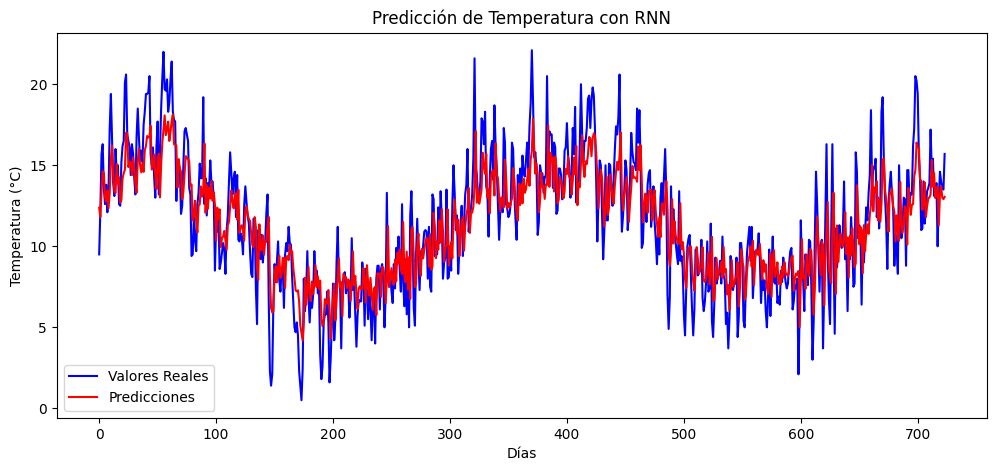

In [10]:
#Visualización de los resultados a través de un gráfico
plt.figure(figsize=(12, 5))
plt.plot(test_y_inv, label='Valores Reales', color='blue')
plt.plot(pred_y_inv, label='Predicciones', color='red')
plt.title('Predicción de Temperatura con RNN')
plt.xlabel('Días')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()

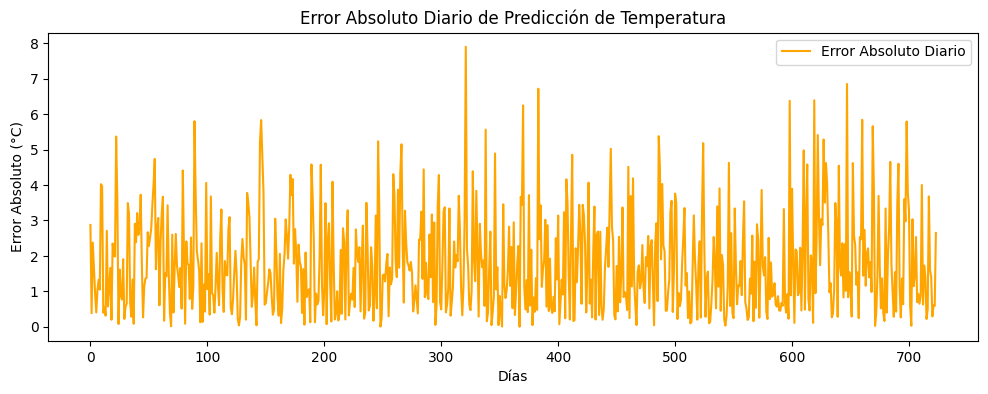

In [11]:
#Grafico con el error de predicción diario
abs_error = np.abs(test_y_inv - pred_y_inv)
plt.figure(figsize=(12, 4))
plt.plot(abs_error, label='Error Absoluto Diario', color='orange')
plt.title('Error Absoluto Diario de Predicción de Temperatura')
plt.xlabel('Días')
plt.ylabel('Error Absoluto (°C)')
plt.legend()
plt.show()

--Guardado del modelo entrenado--

In [12]:
#Guardado del modelo entrenado
model.save('D:\\Hacking\\Python\\AI_Learning\\Aprendizaje_Profundo\\Temperature_Melb_SimpleRNN\\melb_temp_rnn_model.keras')

#Guardado del escalador para normalizar los datos
joblib.dump(scaler, 'D:\\Hacking\\Python\\AI_Learning\\Aprendizaje_Profundo\\Temperature_Melb_SimpleRNN\\melb_temp_scaler.pkl')


['D:\\Hacking\\Python\\AI_Learning\\Aprendizaje_Profundo\\Temperature_Melb_SimpleRNN\\melb_temp_scaler.pkl']

--Cargado el modelo entrenado--

In [13]:
#Cargado del escalador para normalizar los datos
scaler = joblib.load('D:\\Hacking\\Python\\AI_Learning\\Aprendizaje_Profundo\\Temperature_Melb_SimpleRNN\\melb_temp_scaler.pkl')

model_loaded = load_model('D:\\Hacking\\Python\\AI_Learning\\Aprendizaje_Profundo\\Temperature_Melb_SimpleRNN\\melb_temp_rnn_model.keras')

--Predicción sobre los próximos 7 dias--

In [14]:
def predict_multistep(model, input_seq, scaler, days=7):
    """
    Predice múltiples dias hacia adelante.
    
    Args:
        data: Datos de entrada normalizados.
        input_seq: array numpy de la ultima secuencia conocida(steps, 1)
        days: Número de dia a predecir.
        
    Returns:
        preds: lista con las predicciones desnormalizadas.
    """
    preds = []
    current_seq = input_seq.reshape(1, -1, 1)  # Reshape para el modelo RNN
    
    for _ in range(days):
        pred = model.predict(current_seq, verbose=0)  # Realizar la predicción
        preds.append(pred[0, 0])  # Agregar la predicción a la lista
        current_seq = np.append(current_seq[:, 1:, :], pred.reshape(1, 1, 1), axis=1)  # Actualizar la secuencia de entrada
    
    preds = np.array(preds).reshape(-1, 1)  # Convertir a array 2D para desnormalizar
    return scaler.inverse_transform(preds)  # Desnormalizar las predicciones

In [15]:
#Tomamos la última secuencia de datos normalizados
last_seq = temp_scaled[-steps:]  # Última secuencia de datos normalizados

#Predicción de los próximos 7 días
predicted_next_days = predict_multistep(model_loaded, last_seq, scaler, days=7)
print("Predicciones para los próximos 7 días:")
#Bucle para imprimir las predicciones
for i, temp in enumerate(predicted_next_days.flatten(), start=1):
    print(f"Día {i}: {temp:.2f}°C")

Predicciones para los próximos 7 días:
Día 1: 12.75°C
Día 2: 12.87°C
Día 3: 12.93°C
Día 4: 12.85°C
Día 5: 12.66°C
Día 6: 12.58°C
Día 7: 12.44°C


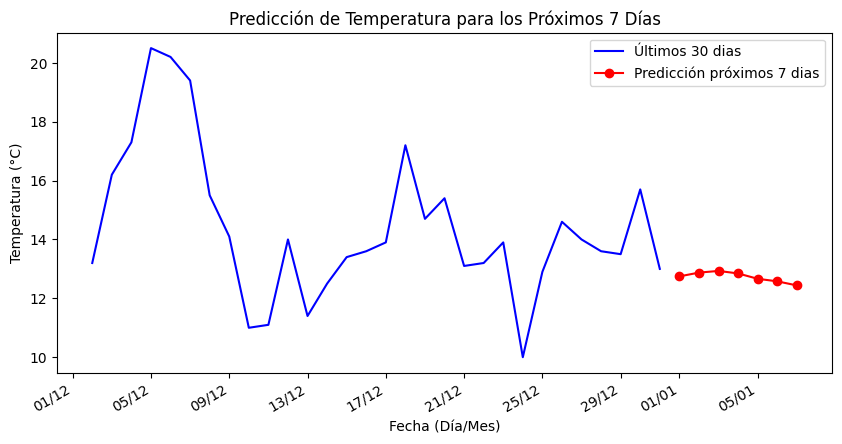

In [16]:
#Generación de fechas para las predicciones futuras
future_dates = pd.date_range(start=melb_temp_data.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')

#Visualización de las predicciones para los próximos 7 días
plt.figure(figsize=(10, 5))
plt.plot(melb_temp_data.index[-30:], scaler.inverse_transform(temp_scaled[-30:]), label='Últimos 30 dias', color='blue')
plt.plot(future_dates, predicted_next_days, label='Predicción próximos 7 dias', marker='o', color='red')
plt.title('Predicción de Temperatura para los Próximos 7 Días')
plt.xlabel('Fecha (Día/Mes)')
plt.ylabel('Temperatura (°C)')
plt.legend()

#Formateo de las fechas en el eje x
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d/%m'))
plt.gcf().autofmt_xdate()  # Rotar las etiquetas del eje x para mejor visibilidad
plt.show()